In [1]:
import os
os.chdir('..')

In [2]:
import numpy as np
import pandas as pd
from nilmtk import STATS_CACHE

from utils.constants import DatasetType, DAY_IN_SEC
from utils.data_reading import clean_and_store_data, read_cleaned_data, \
    convert_to_nilmtk_format, store_processed_stable_periods, \
    get_full_keys_of_stable_periods, read_stable_periods, build_full_key, parse_full_key
from utils.informative_index import accumulated_distance
from utils.preprocessing import generate_sync_signals, get_stable_periods, \
    interpolate_missed_data, generate_async_signals, reformat_to_accumulated
from utils.timing import time_measure
from utils.visualization import plot_sync_async_comparison

from utils.preprocessing import datetime_index_to_ints
import matplotlib.pyplot as plt
import pandas as pd


STATS_CACHE.store.close()


DS = DatasetType.REDD
DURATION = DAY_IN_SEC*1
MAX_GAP = 10

In [3]:
def day_sort(data: pd.Series) -> np.array:
    # assert one day length
    last_timestamp = data.index[0]
    t = last_timestamp.time()
    total_seconds = t.hour*3600 + t.minute*60 + t.second
    day_start = 60*60*24 - total_seconds
    day_power = np.concatenate((data.values[day_start:], data.values[:day_start]))
    return day_power


In [4]:
key_base = build_full_key('', DURATION, MAX_GAP, '')
full_keys_redd  = get_full_keys_of_stable_periods(DatasetType.REDD,  key_base, power_mode=True)
full_keys_ideal = get_full_keys_of_stable_periods(DatasetType.IDEAL, key_base, power_mode=True)
print(len(full_keys_redd))
print(len(full_keys_ideal))

54
3377


In [5]:
all_power_redd  = read_stable_periods(DatasetType.REDD,  full_keys_redd,  power_mode=True)
all_power_ideal = read_stable_periods(DatasetType.IDEAL, full_keys_ideal, power_mode=True)

avg_power_redd  = sum([day_sort(p) for p in all_power_redd])  / len(all_power_redd)
avg_power_ideal = sum([day_sort(p) for p in all_power_ideal]) / len(all_power_ideal)

[reading 54 stable periods of REDD] finished in 0m 1.45s
[reading 3377 stable periods of IDEAL] finished in 0m 58.69s


In [6]:
def moving_average(x: np.array, minutes: int) -> np.array:
    if minutes <= 0:
        return x
    w = minutes * 60
    padded = np.concatenate((x[-w//2:], x, x[:w//2-1]))
    return np.convolve(padded, np.ones(w), 'valid') / w

def plot_day_power(power: np.array, minutes: int = 0) -> None:
    # add assert for length of one day
    fig, ax = plt.subplots(figsize=(13, 5))
    major_ticks = np.arange(0, 25, 2)
    ax.set_xticks(major_ticks)
    ax.grid(True)
    ax.plot(np.array(range(86400))/3600, moving_average(power, minutes))

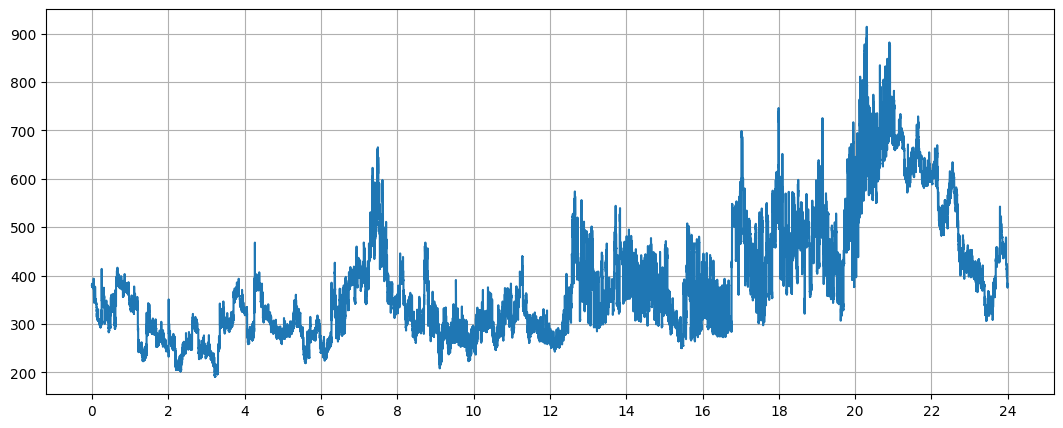

In [7]:
plot_day_power(avg_power_redd, 0)

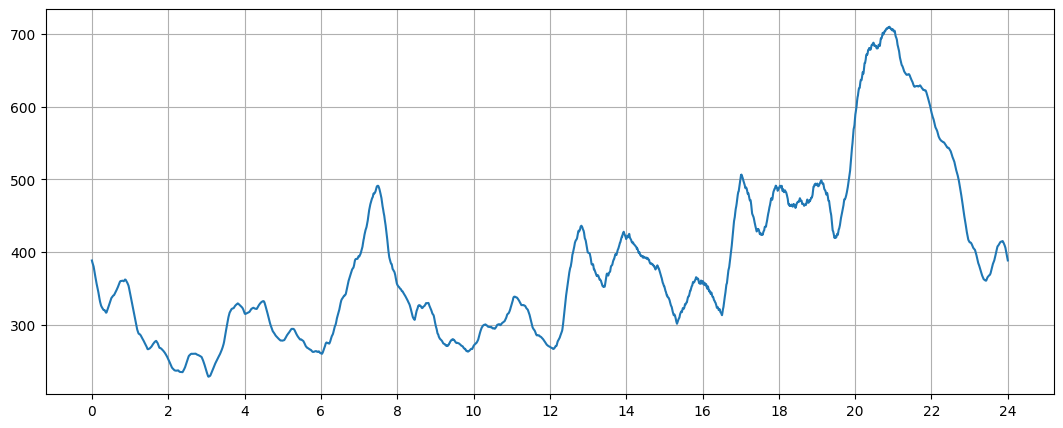

In [8]:
plot_day_power(avg_power_redd, 30)

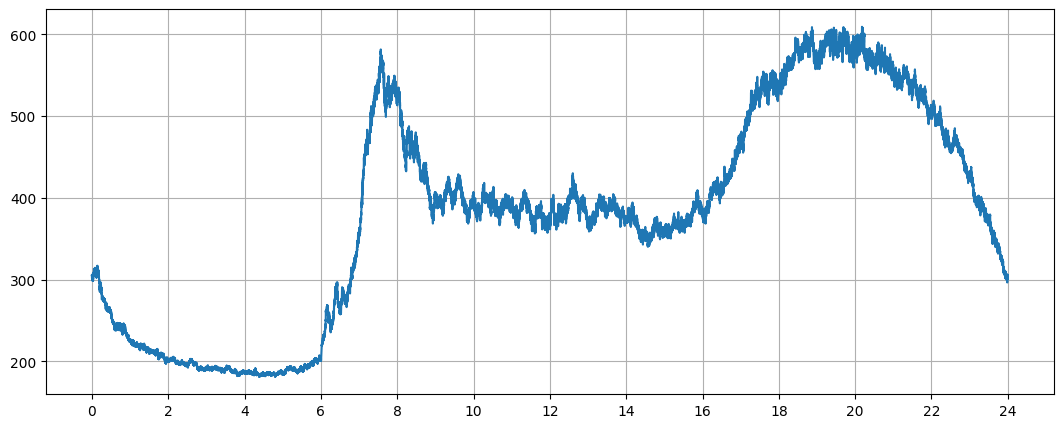

In [9]:
plot_day_power(avg_power_ideal, 0)

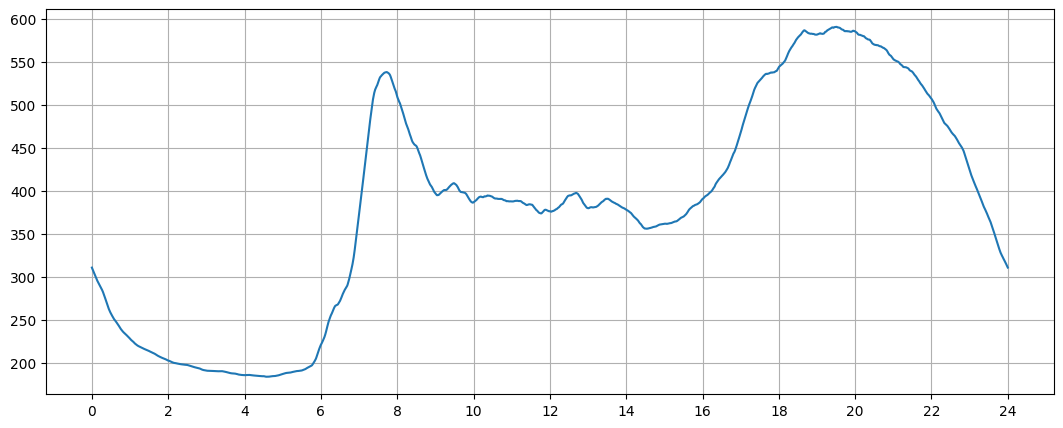

In [10]:
plot_day_power(avg_power_ideal, 30)

In [4]:
from utils.constants import DURATION_MAX_GAP_PAIRS

for dur, gap in DURATION_MAX_GAP_PAIRS:
    key_base = build_full_key('', dur, gap, '')
    full_keys_redd  = get_full_keys_of_stable_periods(DatasetType.REDD,  key_base)
    full_keys_ideal = get_full_keys_of_stable_periods(DatasetType.IDEAL, key_base)
    print(dur // (60*60*24), gap, len(full_keys_redd), len(full_keys_ideal), sep='\t')

30	300	0	20
20	300	0	70
15	300	0	112
10	300	1	293
20	180	0	31
15	180	0	81
10	180	0	197
15	90	0	32
10	90	0	126
5	90	2	589
14	60	0	20
10	60	0	75
7	60	0	218
5	60	2	467
10	30	0	47
7	30	0	121
5	30	1	345
3	30	6	1015
7	15	0	61
5	15	1	200
3	15	6	720
5	10	1	47
3	10	6	302
1	10	54	3377
5	5	1	7
3	5	5	40
1	5	49	936
5	1	1	0
3	1	5	0
1	1	49	0


In [3]:
full_keys_redd  = get_full_keys_of_stable_periods(DatasetType.REDD)
full_keys_ideal = get_full_keys_of_stable_periods(DatasetType.IDEAL)

keys_redd  = set([parse_full_key(k)[0] for k in full_keys_redd])
keys_ideal = set([parse_full_key(k)[0] for k in full_keys_ideal])

print(len(keys_redd))
print(len(keys_ideal))

5
39
